# Fiat Accompli Sortition for Peras and/or Leios
This notebook is best viewed at https://nbviewer.org/.

## Require libraries

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Read epoch stake data

The following query on `cardano-db-sync` was used to fetch epoch stake data:

```sql
create temporary table stake_distribution as
select
    epoch_no                  as "Epoch"
  , encode(hash_raw, 'hex')   as "Pool"
  , sum(amount)               as "Stake [Lovelace]"
  , sum(amount) / total_stake as "Stake [Fraction]"
  from epoch_stake
  inner join pool_hash
    on epoch_stake.pool_id = pool_hash.id
  inner join (
    select epoch_no, sum(amount) as total_stake
      from epoch_stake
      group by epoch_no
  ) stake_total
    using (epoch_no)
  where epoch_no < (select max(epoch_no) from epoch_stake)
  group by epoch_no, hash_raw, total_stake
;

\copy stake_distribution to 'stake_distribution.csv' csv header
```

Read the stake distribution data.

In [2]:
stakeDistribution <-
    fread({
        if (file.exists("../analysis/stake_distribution.csv.gz")) 
            "../analysis/stake_distribution.csv.gz"
        else
            "http://ipfs.io/ipfs/QmauaDo8ZvDRsjfBj8kTctAXKWtQXmon3F4XeaviSELosS"
    })[order(`Epoch`, `Stake [Lovelace]`)][`Stake [Lovelace]` > 0]
stakeDistribution %>% summary

     Epoch           Pool           Stake [Lovelace]         
 Min.   :210.0   Length:868485      Min.   :             16  
 1st Qu.:313.0   Class :character   1st Qu.:     2342124049  
 Median :385.0   Mode  :character   Median :   152289051568  
 Mean   :384.9                      Mean   :  8550462693311  
 3rd Qu.:460.0                      3rd Qu.:  4564051545920  
 Max.   :535.0                      Max.   :486514766981074  
 Stake [Fraction]   
 Min.   :0.000e+00  
 1st Qu.:1.010e-07  
 Median :6.647e-06  
 Mean   :3.754e-04  
 3rd Qu.:1.978e-04  
 Max.   :3.107e-02  

Use the most recent epoch.

In [3]:
lastEpoch <- stakeDistribution[, max(`Epoch`)]
lastEpoch

[1] 535

Make a note of the number of active stake pools.

In [4]:
nPools <- stakeDistribution[`Epoch` == lastEpoch, .N]
nPools

[1] 2792

## Fiat accompli sortition

We start with the stake distribution $S$, ordered by decreasing stake.

In [5]:
S <- stakeDistribution[`Epoch` == lastEpoch][order(-`Stake [Fraction]`)][, `Stake [Fraction]`]

The quantity $\rho$ is the cumulative sum of $S$, starting from the *smallest* stake.

In [6]:
ρ <- rev(cumsum(rev(S)))

## Scheme wFA<sup>F</sup>

The weighted scheme wFA<sup>F</sup> creates persistent voters until a particular inequality fails to be satisfied.

In [7]:
wFA <- function(n) {
    i <- 1:n
    iStar <- which(
        ((1 - S / ρ)^2)[1:n] >= (n - i) / (n - i + 1)
    )[1]
    list(
        `Persistent Voters` = iStar - 1,
        `Persistent Stake` = (1 - ρ[iStar])
    )
}

In [8]:
results <- CJ(`Committee Size`=1:1250, `Scheme`="wFA")
results[`Scheme` == "wFA", 
    c("Persistent Voters", "Persistent Stake"):=mapply(wFA, `Committee Size`),
    by=.(`Committee Size`)
]

### Number of persistent voters

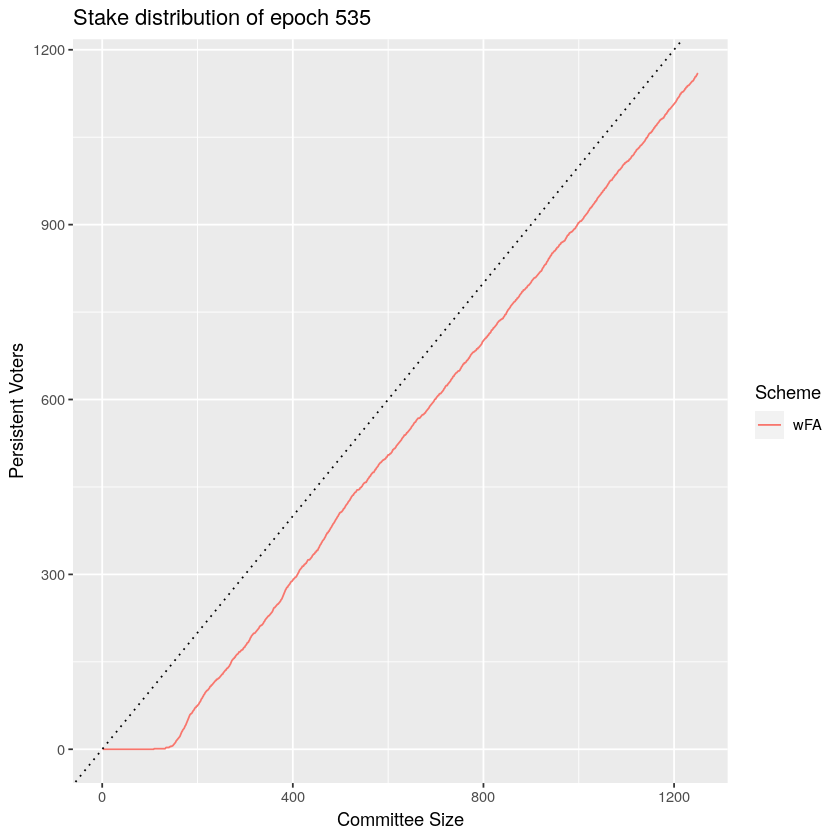

In [9]:
ggplot(results, aes(x=`Committee Size`, y=`Persistent Voters`, color=`Scheme`)) +
  geom_line() +
  geom_abline(intercept=0, slope=1, linetype="dotted") +
  ggtitle(paste("Stake distribution of epoch", lastEpoch))

### Variability in total weight

In [10]:
results[`Committee Size` %in% c(500, 600, 700, 800, 900, 1000, 1100, 1200)][
    ,
    .(
        `Committee Size`,
        `Scheme`,
        `Persistent Seats`=`Persistent Voters`,
        `Persistent Weight`=`Persistent Stake`,
        `Standard Deviation of Total Weight`=(1-`Persistent Stake`)/sqrt(`Committee Size`-`Persistent Voters`),
        `1 ppm Tail of Total Weight`=(1-`Persistent Stake`)*mapply(function(n2) qpois(1e-6, n2)/n2, `Committee Size`-`Persistent Voters`)
    )
]

Committee Size,Scheme,Persistent Seats,Persistent Weight,Standard Deviation of Total Weight,1 ppm Tail of Total Weight
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
500,wFA,406,0.8237168,0.0181822269,0.097518383
600,wFA,505,0.8964108,0.0106280267,0.056701452
700,wFA,601,0.9367007,0.0063618203,0.035166285
800,wFA,701,0.9618550,0.0038337146,0.021191655
900,wFA,801,0.9770417,0.0023073956,0.012754609
1000,wFA,903,0.9864321,0.0013776087,0.007553248
1100,wFA,1007,0.9921898,0.0008098848,0.004283038
1200,wFA,1107,0.9954256,0.0004743450,0.002508552
